In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
import matplotlib.gridspec as gridspec

In [2]:
# Open SST dataset
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst'].load()

In [3]:
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
sst_land = xr.where(land_110.mask_3D(sst)==False, 1, np.nan).squeeze()

In [4]:
# Fill values
sst_fill = (sst*sst_land).where(sst > -1.8, -1.8)

In [5]:
# Remove seasonal cycle
sst_fill_anoms = sst_fill.groupby('time.month') - sst_fill.groupby('time.month').mean()

In [6]:
# Calculate global mean SSTA
sst_anoms_mean = sst_fill_anoms.weighted(np.cos(np.deg2rad(sst_fill_anoms.latitude))).mean(dim=('latitude', 'longitude'))
sst_anoms_mean_noarctic = sst_fill_anoms.sel(latitude=slice(60, -60)).weighted(np.cos(np.deg2rad(sst_fill_anoms.sel(latitude=slice(60, -60)).latitude))).mean(dim=('latitude', 'longitude'))

In [7]:
# Subtract the global mean
sst_anoms_ts = sst_fill_anoms - sst_anoms_mean
sst_anoms_noarctic_ts = sst_fill_anoms - sst_anoms_mean_noarctic

In [8]:
# Regress SSTA onto G
ssta_on_g = pdo_functions.linregress_3D(sst_anoms_ts, sst_fill_anoms)[2]
ssta_on_g_noarctic = pdo_functions.linregress_3D(sst_anoms_noarctic_ts, sst_fill_anoms)[2]

In [9]:
# Scale by g
ssta_on_g_scale = sst_anoms_mean.expand_dims({'latitude':sst_fill_anoms['latitude'], 'longitude':sst_fill_anoms['longitude']}).values * ssta_on_g[:, :, np.newaxis]
ssta_on_g_scale_noarctic = sst_anoms_mean_noarctic.expand_dims({'latitude':sst_fill_anoms['latitude'], 'longitude':sst_fill_anoms['longitude']}).values * ssta_on_g_noarctic[:, :, np.newaxis]

In [10]:
# Subtract scaled by g from sst_anoms
sst_anoms_resid = sst_fill_anoms - ssta_on_g_scale.swapaxes(0, 2).swapaxes(1, 2)
sst_anoms_resid_noarctic = sst_fill_anoms - ssta_on_g_scale_noarctic.swapaxes(0, 2).swapaxes(1, 2)

Text(0.5, 1.0, 'Global Mean SST Anomalies')

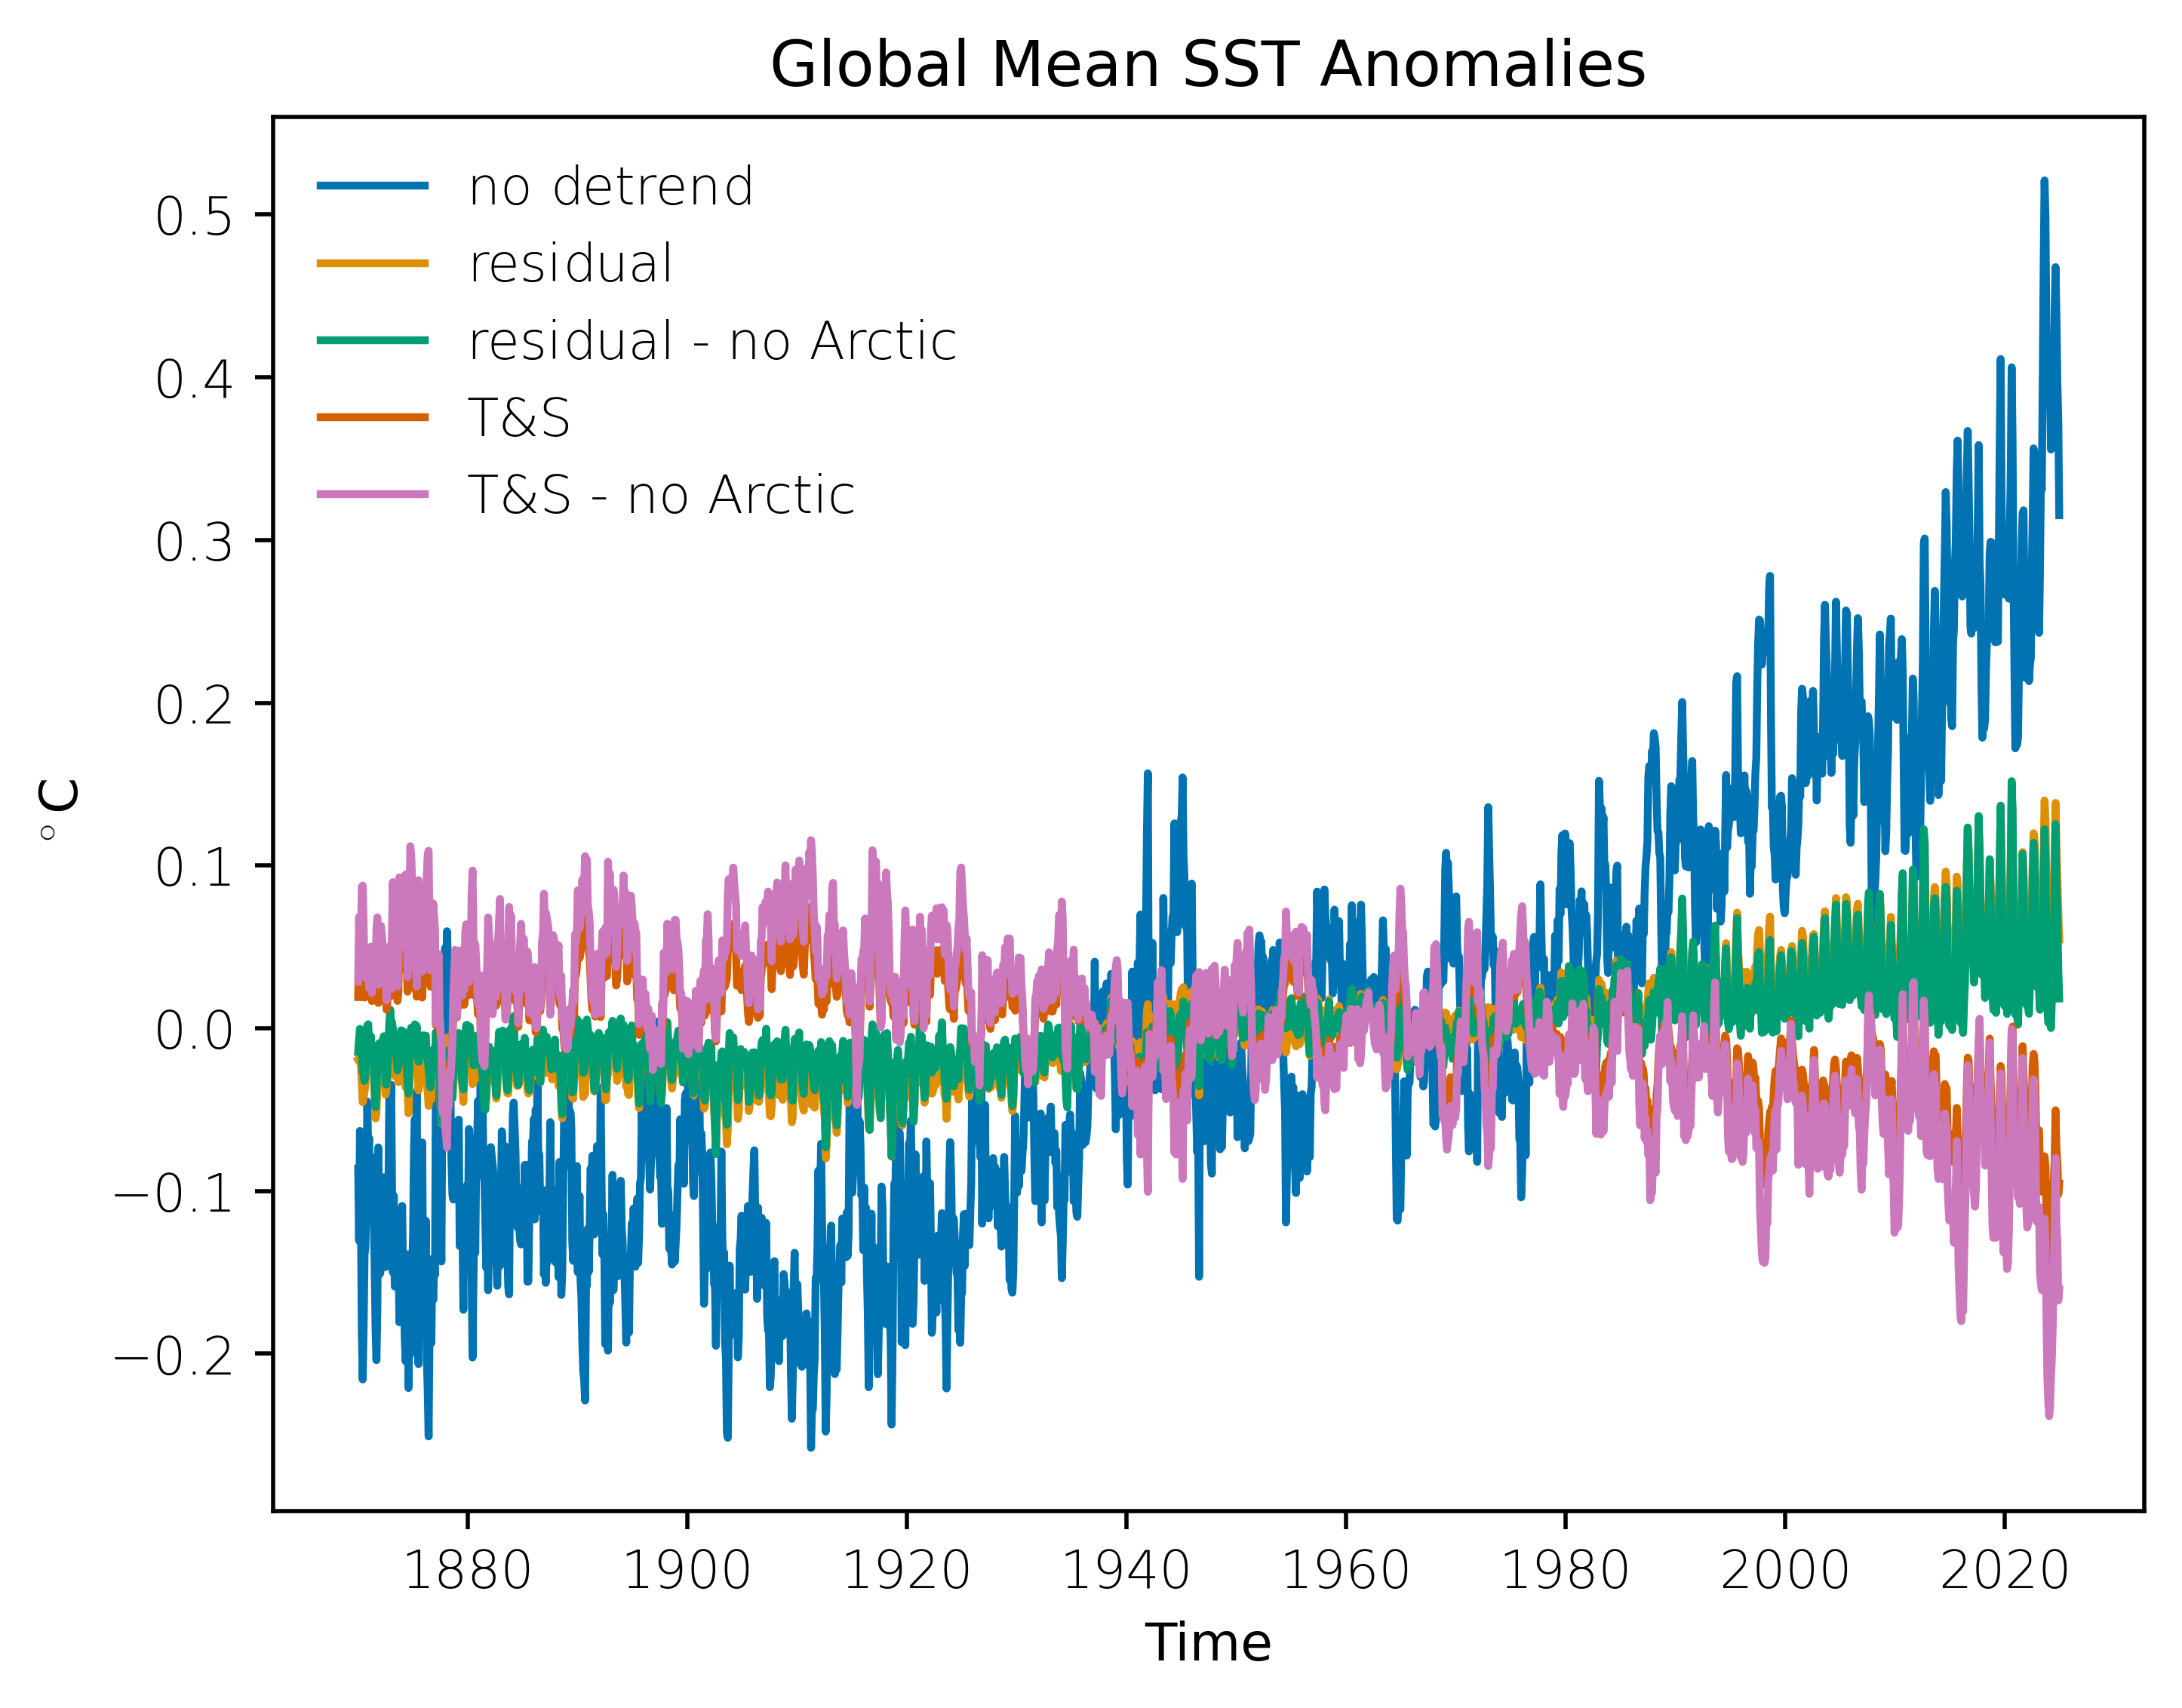

In [11]:
sst_fill_anoms.mean(dim=('latitude', 'longitude')).plot(label='no detrend')
sst_anoms_resid.mean(dim=('latitude', 'longitude')).plot(label='residual')
sst_anoms_resid_noarctic.mean(dim=('latitude', 'longitude')).plot(label='residual - no Arctic')
sst_anoms_ts.mean(dim=('latitude', 'longitude')).plot(label='T&S')
sst_anoms_noarctic_ts.mean(dim=('latitude', 'longitude')).plot(label='T&S - no Arctic')

plt.legend(frameon=False)
plt.ylabel('$^\circ$C')
plt.title('Global Mean SST Anomalies')

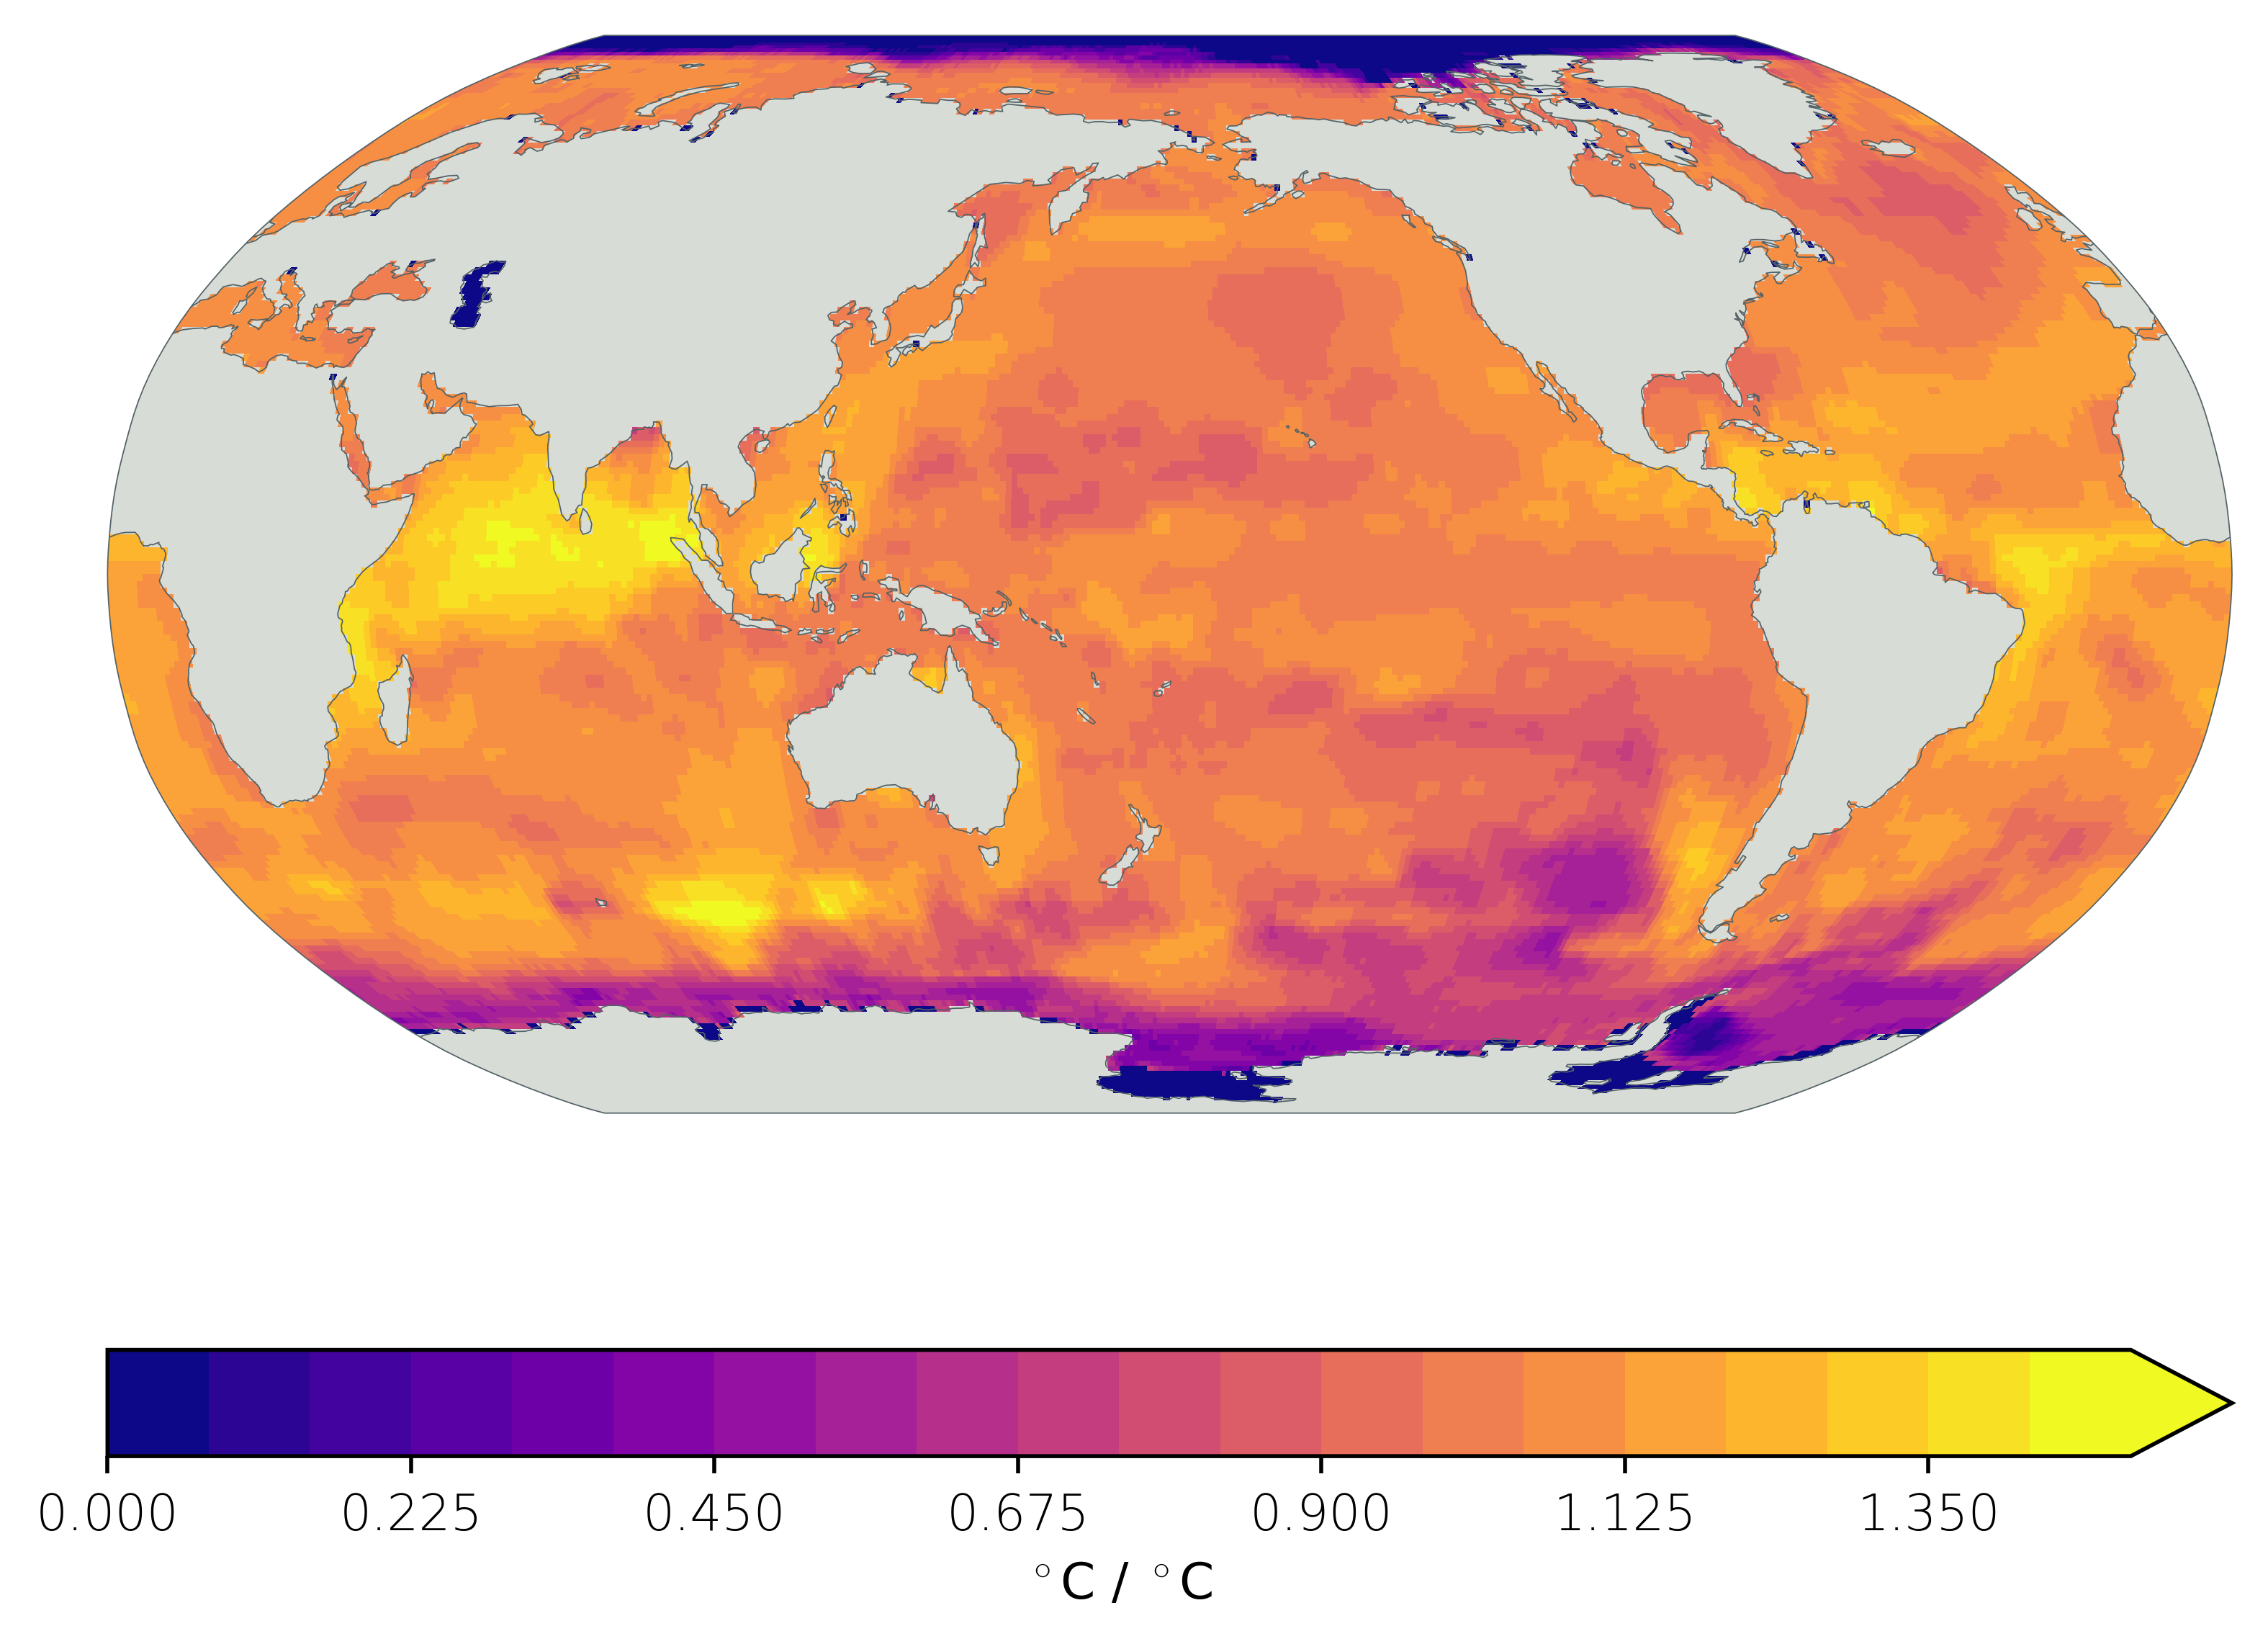

In [12]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

bounds = np.arange(0, 1.575, 0.075)

norm = c.BoundaryNorm(bounds, plt.get_cmap('plasma').N)

ax.coastlines(lw=0.25, color='xkcd:gunmetal')
ax.spines['geo'].set_linewidth(0.25)
ax.spines['geo'].set_edgecolor('xkcd:gunmetal')
ax.set_facecolor('xkcd:light gray')

im = ax.pcolormesh(sst['longitude'], sst['latitude'], ssta_on_g_noarctic*sst_land, transform=ccrs.PlateCarree(), shading='auto', cmap='plasma', norm=norm)

fig.colorbar(im, orientation='horizontal', label='$^\circ$C / $^\circ$C', extend='max')

plt.tight_layout()

In [13]:
# Subset PDO region
sst_anoms_no_climo_pdo = xr.concat([sst_fill_anoms.sel(latitude=slice(70, 20)).sel(longitude=slice(110, 180)), \
                                    sst_fill_anoms.sel(latitude=slice(70, 20)).sel(longitude=slice(-180, -100))], dim='longitude')

sst_anoms_ts_pdo = xr.concat([sst_anoms_ts.sel(latitude=slice(70, 20)).sel(longitude=slice(110, 180)), \
                              sst_anoms_ts.sel(latitude=slice(70, 20)).sel(longitude=slice(-180, -100))], dim='longitude')

sst_anoms_resid_pdo = xr.concat([sst_anoms_resid.sel(latitude=slice(70, 20)).sel(longitude=slice(110, 180)), \
                                 sst_anoms_resid.sel(latitude=slice(70, 20)).sel(longitude=slice(-180, -100))], dim='longitude')

sst_anoms_ts_noarctic_pdo = xr.concat([sst_anoms_noarctic_ts.sel(latitude=slice(70, 20)).sel(longitude=slice(110, 180)), \
                                       sst_anoms_noarctic_ts.sel(latitude=slice(70, 20)).sel(longitude=slice(-180, -100))], dim='longitude')

sst_anoms_resid_noarctic_pdo = xr.concat([sst_anoms_resid_noarctic.sel(latitude=slice(70, 20)).sel(longitude=slice(110, 180)), \
                                          sst_anoms_resid_noarctic.sel(latitude=slice(70, 20)).sel(longitude=slice(-180, -100))], dim='longitude')

In [14]:
# Weight by the square root of the cosine of the latitude
sst_anoms_no_climo_pdo_wgt = sst_anoms_no_climo_pdo * np.sqrt(np.cos(np.deg2rad(sst_anoms_no_climo_pdo.latitude)))
sst_anoms_ts_pdo_wgt = sst_anoms_ts_pdo * np.sqrt(np.cos(np.deg2rad(sst_anoms_ts_pdo.latitude)))
sst_anoms_resid_pdo_wgt = sst_anoms_resid_pdo * np.sqrt(np.cos(np.deg2rad(sst_anoms_resid_pdo.latitude)))
sst_anoms_ts_noarctic_pdo_wgt = sst_anoms_ts_noarctic_pdo * np.sqrt(np.cos(np.deg2rad(sst_anoms_ts_pdo.latitude)))
sst_anoms_resid_noarctic_pdo_wgt = sst_anoms_resid_noarctic_pdo * np.sqrt(np.cos(np.deg2rad(sst_anoms_resid_pdo.latitude)))

In [17]:
# EOF
eof = eofunc_eofs(sst_anoms_ts_pdo_wgt, neofs=1)
eof_resid = eofunc_eofs(sst_anoms_resid_pdo_wgt, neofs=1)
eof_noclimo = eofunc_eofs(sst_anoms_no_climo_pdo_wgt, neofs=1)
eof_resid_noarctic = eofunc_eofs(sst_anoms_resid_noarctic_pdo_wgt, neofs=1)
eof_noarctic = eofunc_eofs(sst_anoms_ts_noarctic_pdo_wgt, neofs=1)

# Reshape
eof_reshape = np.reshape((eof[0].values*-1), 50*150)
eof_resid_reshape = np.reshape((eof_resid[0].values), 50*150)
eof_noclimo_reshape = np.reshape((eof_noclimo[0].values), 50*150)
eof_resid_noarctic_reshape = np.reshape((eof_resid_noarctic[0].values), 50*150)
eof_noclimo_noarctic_reshape = np.reshape((eof_noarctic[0].values), 50*150)

ssta_tseries_reshape = np.reshape(sst_anoms_ts_pdo_wgt.transpose('latitude', 'longitude', 'time').values, (50*150, 1860))
ssta_resid_tseries_reshape = np.reshape(sst_anoms_resid_pdo_wgt.transpose('latitude', 'longitude', 'time').values, (50*150, 1860))
ssta_noclimo_tseries_reshape = np.reshape(sst_anoms_no_climo_pdo_wgt.transpose('latitude', 'longitude', 'time').values, (50*150, 1860))
ssta_resid_noarctic_tseries_reshape = np.reshape(sst_anoms_resid_noarctic_pdo_wgt.transpose('latitude', 'longitude', 'time').values, (50*150, 1860))
ssta_tseries_noarctic_tseries_reshape = np.reshape(sst_anoms_ts_noarctic_pdo_wgt.transpose('latitude', 'longitude', 'time').values, (50*150, 1860))

pcs = eofunc_pcs(sst_anoms_ts_pdo.data, npcs=1)
pcs_resid = eofunc_pcs(sst_anoms_resid_pdo.data, npcs=1)
pcs_noclimo = eofunc_pcs(sst_anoms_no_climo_pdo.data, npcs=1)
pcs_resid_noarctic = eofunc_pcs(sst_anoms_resid_noarctic_pdo.data, npcs=1)
pcs_noarctic = eofunc_pcs(sst_anoms_ts_noarctic_pdo.data, npcs=1)

# Standardize PCs
standard_pcs = (pcs[0] - pcs[0].mean()) / pcs[0].std()
standard_pcs_resid = (pcs_resid[0] - pcs_resid[0].mean()) / pcs_resid[0].std()
standard_pcs_noclimo = (pcs_noclimo[0] - pcs_noclimo[0].mean()) / pcs_noclimo[0].std()
standard_pcs_resid_noarctic = (pcs_resid_noarctic[0] - pcs_resid_noarctic[0].mean()) / pcs_resid_noarctic[0].std()
standard_pcs_noarctic = (pcs_noarctic[0] - pcs_noarctic[0].mean()) / pcs_noarctic[0].std()

# define my own dot product function for when there are NaNs.
# Note that this does the scaling by 1/M inside it (by taking nanmean), so not a true dot product.
def nandot(X, Y):
    
    C = np.empty([np.size(Y, axis=1)])
    for time in np.arange(0, np.size(Y, axis=1)):
        C[time] = np.nanmean(np.multiply(X, Y[:, time]))
    
    return C

pcs_full = nandot(eof_reshape, ssta_tseries_reshape)
pcs_full_resid = nandot(eof_resid_reshape, ssta_resid_tseries_reshape)

pcs_full_std = (pcs_full - np.mean(pcs_full)) / np.std(pcs_full)
pcs_full_std_resid = (pcs_full_resid - np.mean(pcs_full_resid)) / np.std(pcs_full_resid)

In [18]:
pdo_pattern_resid = pdo_functions.linregress_3D(standard_pcs_resid.values, sst_anoms_resid)[2]

In [19]:
pdo_pattern_resid_noarctic = pdo_functions.linregress_3D(standard_pcs_resid_noarctic.values, sst_anoms_resid_noarctic)[2]

In [20]:
pdo_pattern  = pdo_functions.linregress_3D(standard_pcs.values, sst_anoms_ts)[2]

In [22]:
pdo_pattern_noarctic  = pdo_functions.linregress_3D(standard_pcs_noarctic.values, sst_anoms_noarctic_ts)[2]

In [23]:
pdo_pattern_noclimo = pdo_functions.linregress_3D(standard_pcs_noclimo.values, sst_fill_anoms)[2]

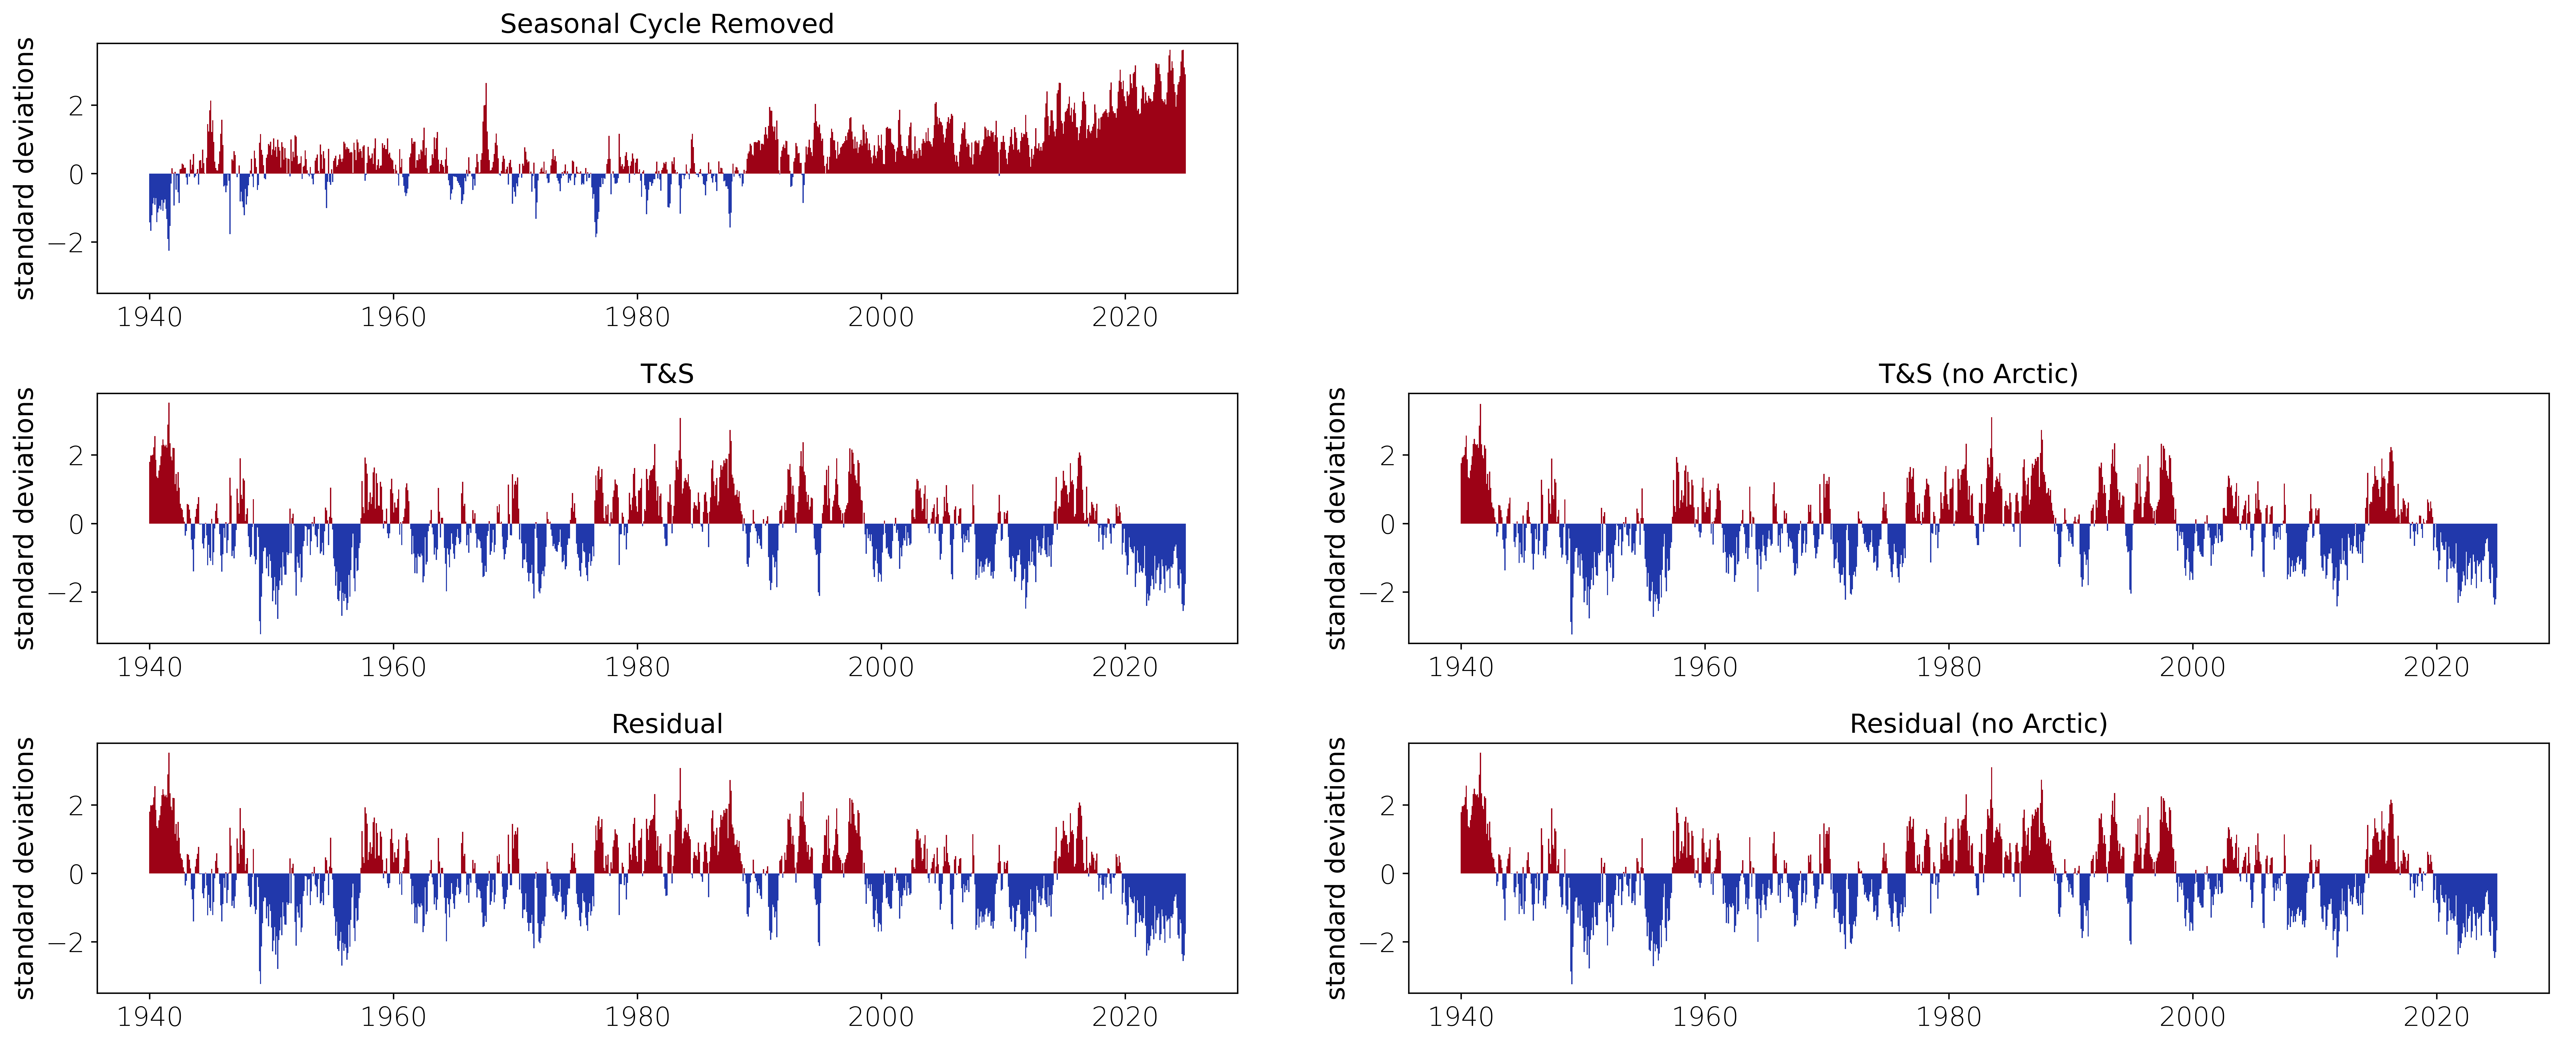

In [95]:
fig, ax = plt.subplots(3, 2)

ax = [ax[0, 0], ax[0, 1], \
      ax[1, 0], ax[1, 1], \
      ax[2, 0], ax[2, 1]]

time = np.arange(1870, 2025, 1/12)

for i in range(6):
    if i == 1:
        for spine in ax[i].spines.values():
            spine.set_color('white')
        # Set tick label color
        ax[i].tick_params(axis='x', colors='white')  # x-axis tick labels
        ax[i].tick_params(axis='y', colors='white')  # y-axis tick labels
    else:
        ax[i].set_ylim(-3.5, 3.8)
        ax[i].tick_params(labelsize=15)
        ax[i].set_ylabel('standard deviations', fontsize=15)

ax[0].bar(time[12*70:][standard_pcs_noclimo[12*70:] > 0], standard_pcs_noclimo[12*70:][standard_pcs_noclimo[12*70:] > 0], color='xkcd:carmine', width=0.1)
ax[0].bar(time[12*70:][standard_pcs_noclimo[12*70:] < 0], standard_pcs_noclimo[12*70:][standard_pcs_noclimo[12*70:] < 0], color='xkcd:sapphire', width=0.1)

ax[2].bar(time[12*70:][standard_pcs[12*70:] > 0], standard_pcs[12*70:][standard_pcs[12*70:] > 0], color='xkcd:carmine', width=0.1)
ax[2].bar(time[12*70:][standard_pcs[12*70:] < 0], standard_pcs[12*70:][standard_pcs[12*70:] < 0], color='xkcd:sapphire', width=0.1)

ax[3].bar(time[12*70:][standard_pcs_noarctic[12*70:] > 0], standard_pcs_noarctic[12*70:][standard_pcs_noarctic[12*70:] > 0], color='xkcd:carmine', width=0.1)
ax[3].bar(time[12*70:][standard_pcs_noarctic[12*70:] < 0], standard_pcs_noarctic[12*70:][standard_pcs_noarctic[12*70:] < 0], color='xkcd:sapphire', width=0.1)

ax[4].bar(time[12*70:][standard_pcs_resid[12*70:]*-1 > 0], (standard_pcs_resid[12*70:]*-1)[standard_pcs_resid[12*70:]*-1 > 0], color='xkcd:carmine', width=0.1)
ax[4].bar(time[12*70:][standard_pcs_resid[12*70:]*-1 < 0], (standard_pcs_resid[12*70:]*-1)[standard_pcs_resid[12*70:]*-1 < 0], color='xkcd:sapphire', width=0.1)

ax[5].bar(time[12*70:][standard_pcs_resid_noarctic[12*70:]*-1 > 0], (standard_pcs_resid_noarctic[12*70:]*-1)[standard_pcs_resid_noarctic[12*70:]*-1 > 0], color='xkcd:carmine', width=0.1)
ax[5].bar(time[12*70:][standard_pcs_resid_noarctic[12*70:]*-1 < 0], (standard_pcs_resid_noarctic[12*70:]*-1)[standard_pcs_resid_noarctic[12*70:]*-1 < 0], color='xkcd:sapphire', width=0.1)

ax[0].set_title('Seasonal Cycle Removed', fontsize=15)
ax[2].set_title('T&S', fontsize=15)
ax[3].set_title('T&S (no Arctic)', fontsize=15)
ax[4].set_title('Residual', fontsize=15)
ax[5].set_title('Residual (no Arctic)', fontsize=15)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=3, 
                    top=1.8, 
                    wspace=0.15, 
                    hspace=0.4)

Text(0, 0.5, 'standard deviations')

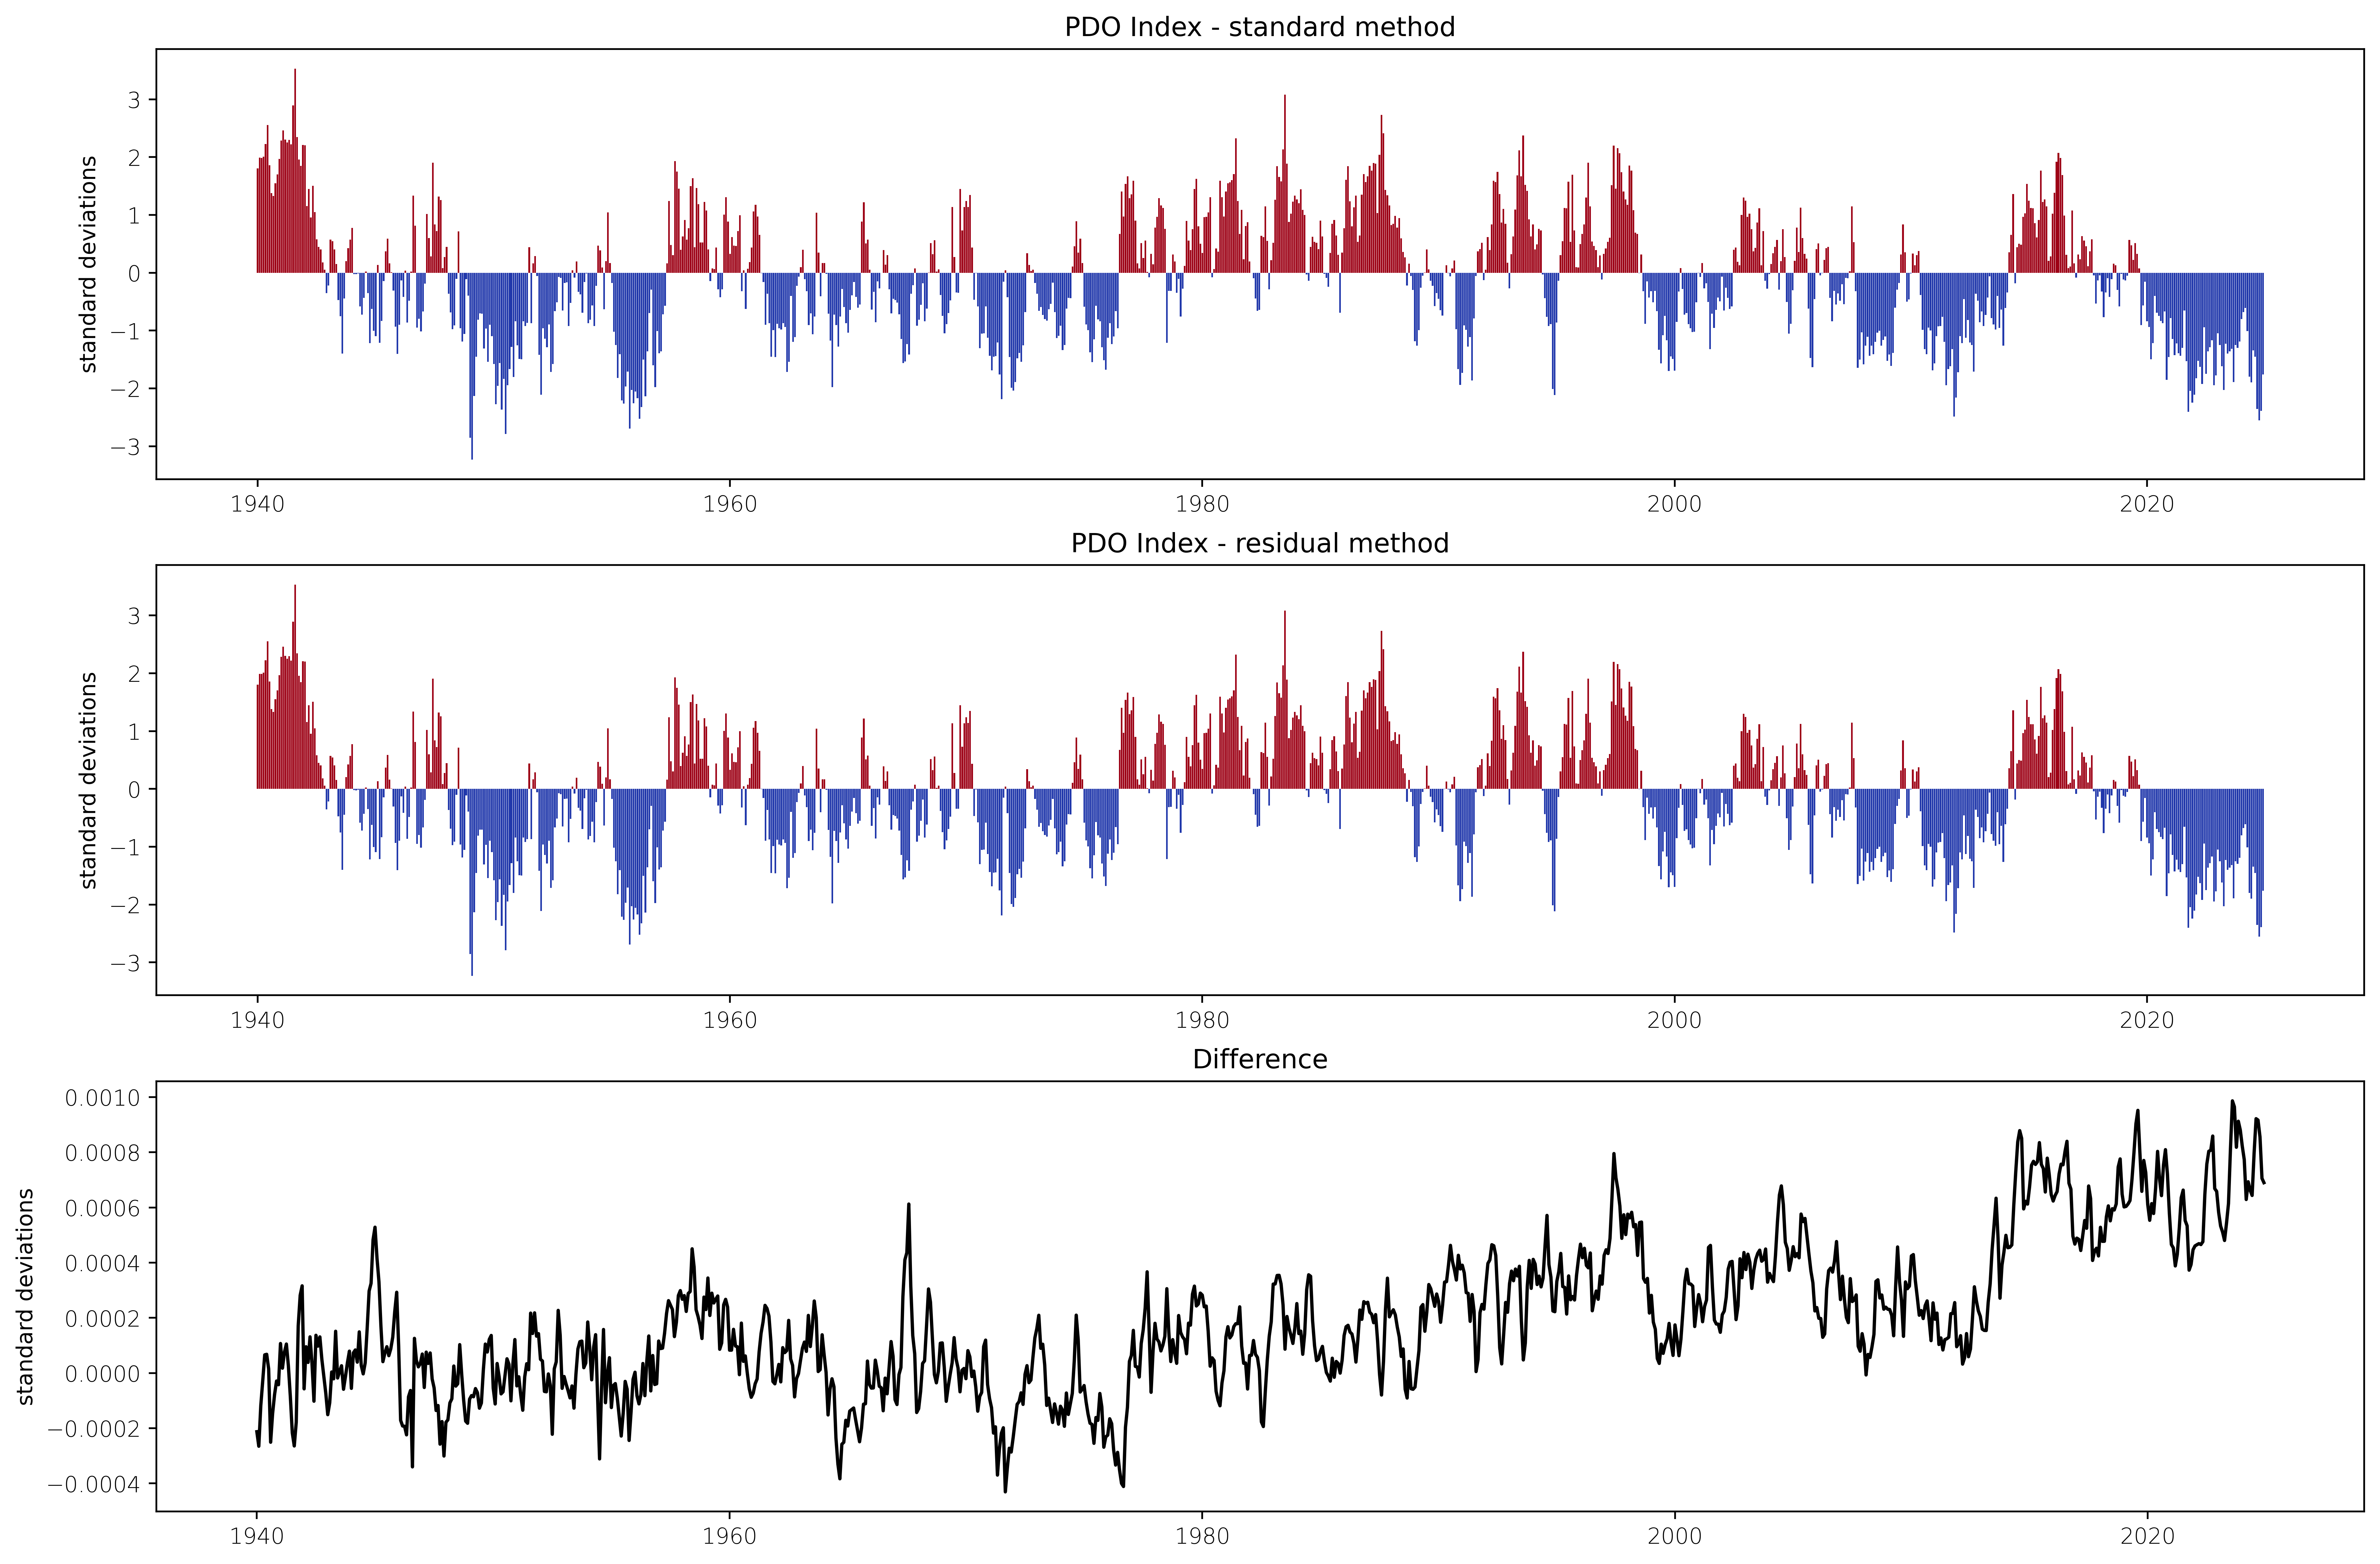

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(18, 12))

time = np.arange(1870, 2025, 1/12)

ax[0].bar(time[12*70:][standard_pcs[12*70:] > 0], standard_pcs[12*70:][standard_pcs[12*70:] > 0], color='xkcd:carmine', width=0.07)
ax[0].bar(time[12*70:][standard_pcs[12*70:] < 0], standard_pcs[12*70:][standard_pcs[12*70:] < 0], color='xkcd:sapphire', width=0.07)

ax[1].bar(time[12*70:][(standard_pcs_resid*-1)[12*70:] > 0], (standard_pcs_resid*-1)[12*70:][(standard_pcs_resid*-1)[12*70:] > 0], color='xkcd:carmine', width=0.07)
ax[1].bar(time[12*70:][(standard_pcs_resid*-1)[12*70:] < 0], (standard_pcs_resid*-1)[12*70:][(standard_pcs_resid*-1)[12*70:] < 0], color='xkcd:sapphire', width=0.07)

ax[2].plot(time[12*70:], standard_pcs[12*70:] - (standard_pcs_resid*-1)[12*70:], color='black')

ax[0].set_title('PDO Index - standard method')
ax[1].set_title('PDO Index - residual method')
ax[2].set_title('Difference')

ax[0].set_ylabel('standard deviations')
ax[1].set_ylabel('standard deviations')
ax[2].set_ylabel('standard deviations')

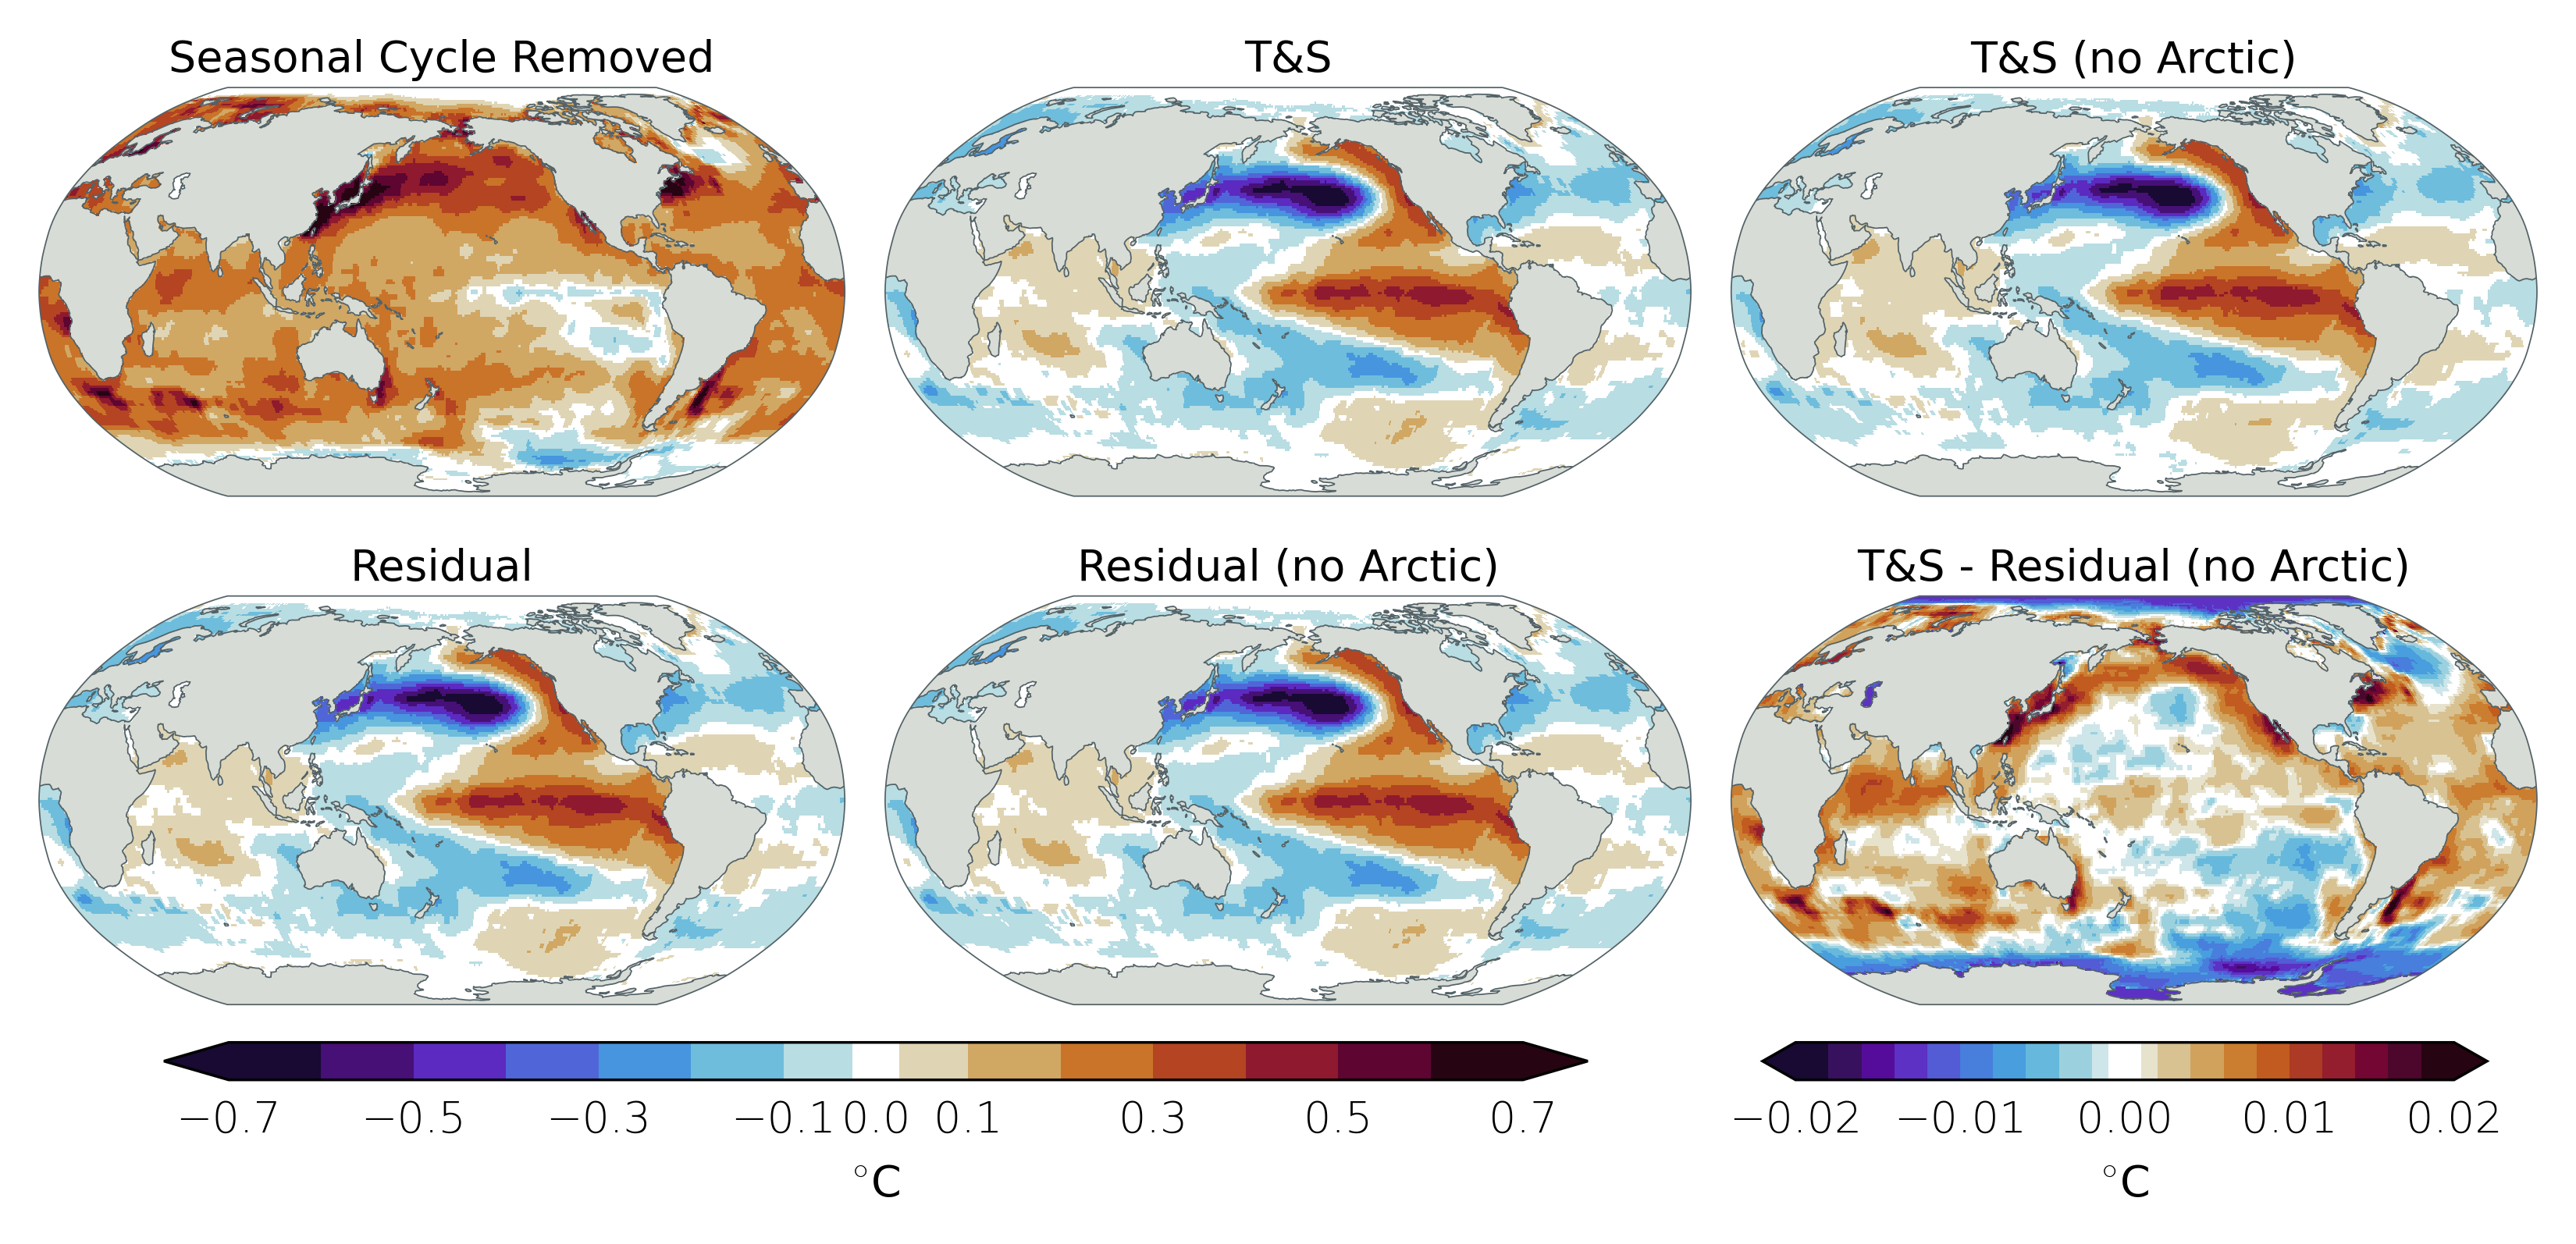

In [55]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

bounds = [-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.025, 0.025, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

norm= c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

bounds_diff = [-0.0002e2, -0.00018e2, -0.00016e2, -0.00014e2, -0.00012e2, -0.0001e2, -0.00008e2, -0.00006e2, -0.00004e2, -0.00002e2, -0.00001e2, 0.00001e2, 0.00002e2, 0.00004e2, 0.00006e2, 0.00008e2, 0.0001e2, 0.00012e2, 0.00014e2, 0.00016e2, 0.00018e2, 0.0002e2]

norm_diff = c.BoundaryNorm(bounds_diff, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(sst['longitude'], sst['latitude'], pdo_pattern_noclimo*sst_land, transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[1].pcolormesh(sst['longitude'], sst['latitude'], pdo_pattern*sst_land, transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[2].pcolormesh(sst['longitude'], sst['latitude'], pdo_pattern_noarctic*sst_land, transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[3].pcolormesh(sst['longitude'], sst['latitude'], pdo_pattern_resid*sst_land*-1, transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[4].pcolormesh(sst['longitude'], sst['latitude'], pdo_pattern_resid_noarctic*sst_land*-1, transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[5].pcolormesh(sst['longitude'], sst['latitude'], (pdo_pattern_noarctic - (pdo_pattern_resid_noarctic*-1))*sst_land, transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm_diff)

ax[0].set_title('Seasonal Cycle Removed', fontsize=8, pad=3)
ax[1].set_title('T&S', fontsize=8, pad=3)
ax[2].set_title('T&S (no Arctic)', fontsize=8, pad=3)
ax[3].set_title('Residual', fontsize=8, pad=3)
ax[4].set_title('Residual (no Arctic)', fontsize=8, pad=3)
ax[5].set_title('T&S - Residual (no Arctic)', fontsize=8, pad=3)

cax = plt.axes([0.05, .23, 0.57, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', ticks=[-0.7, -0.5, -0.3, -0.1, 0, 0.1, 0.3, 0.5, 0.7])
cbar.set_label(r'$^{\circ}$C', size=8, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.69, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm_diff), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', ticks=[-0.02, -0.01, 0, 0.01, 0.02])
cbar2.set_label(r'$^{\circ}$C', size=8, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1, 
                    top=0.78, 
                    wspace=0.05, 
                    hspace=0.05)

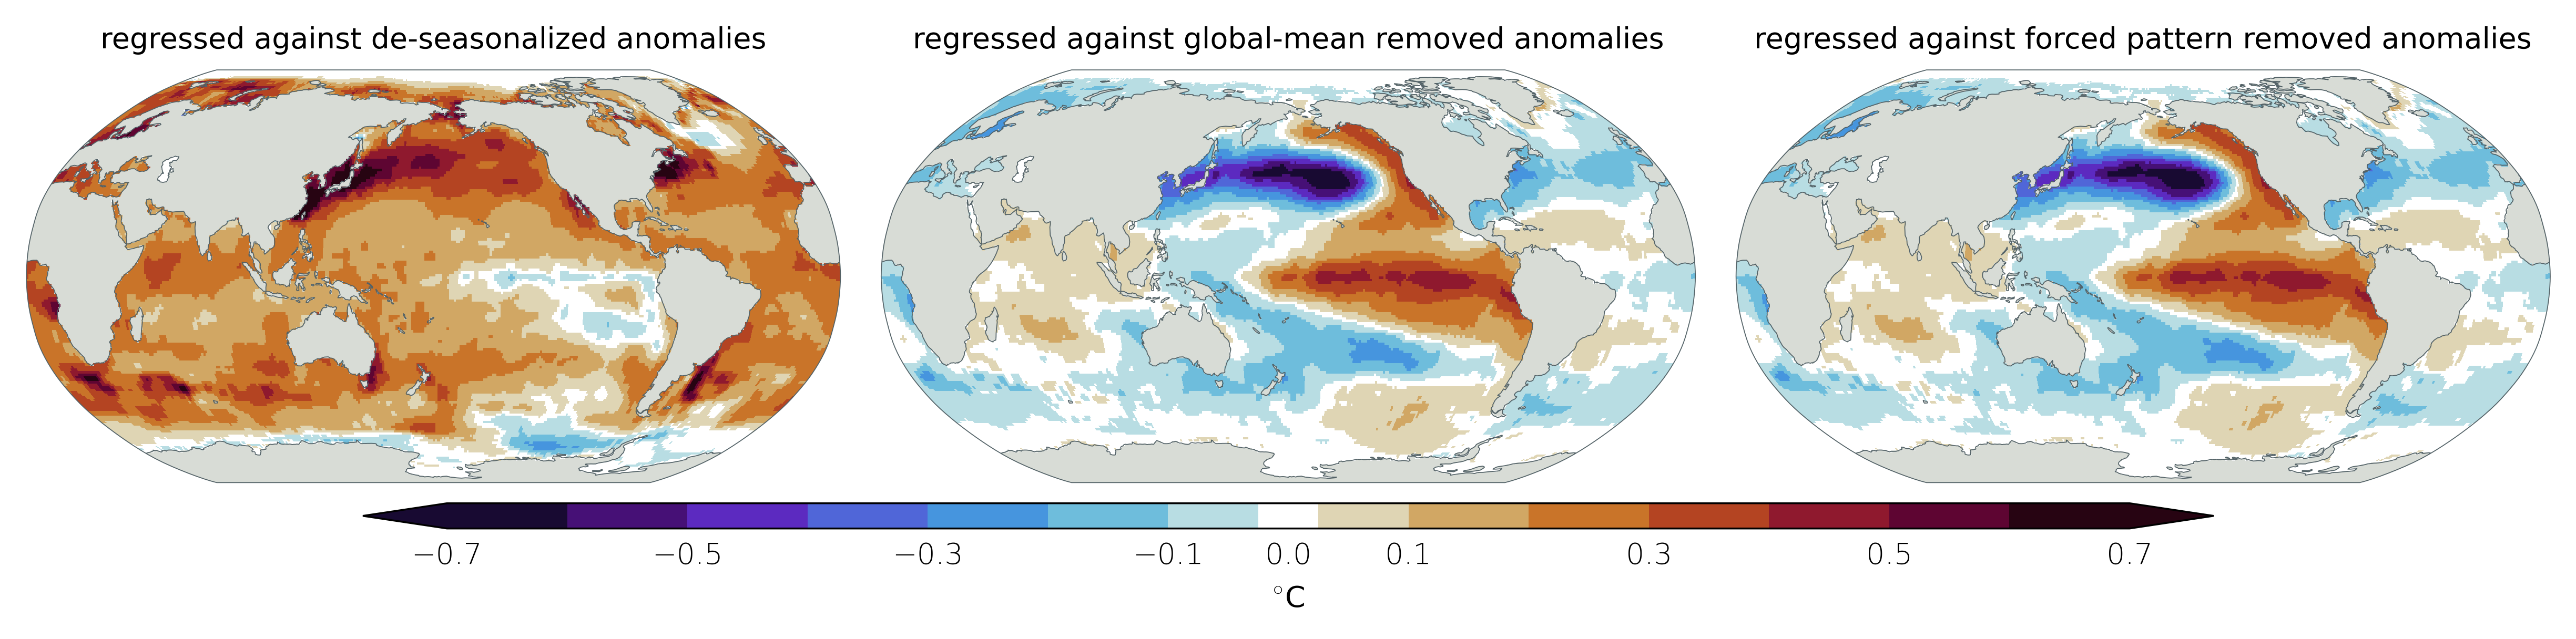

In [21]:
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

bounds = [-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.025, 0.025, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

norm= c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(3):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(sst['longitude'], sst['latitude'], pdo_pattern_noclimo*sst_land, transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[1].pcolormesh(sst['longitude'], sst['latitude'], pdo_pattern*sst_land, transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[2].pcolormesh(sst['longitude'], sst['latitude'], pdo_pattern_resid*sst_land*-1, transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[0].set_title('regressed against de-seasonalized anomalies', fontsize=8)
ax[1].set_title('regressed against global-mean removed anomalies', fontsize=8)
ax[2].set_title('regressed against forced pattern removed anomalies', fontsize=8)

cax = plt.axes([0.2, .3, 1.1, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', ticks=[-0.7, -0.5, -0.3, -0.1, 0, 0.1, 0.3, 0.5, 0.7])
cbar.set_label(r'$^{\circ}$C', size=8, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1.5, 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)